<a href="https://colab.research.google.com/github/erinmcmahon26/Company-Bankruptcy-Prediction-Kaggle/blob/main/Company_Bankruptcy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df_bank = pd.read_csv('https://raw.githubusercontent.com/erinmcmahon26/Company-Bankruptcy-Prediction-Kaggle/main/company_bankruptcy.csv')

In [4]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [5]:
df_bank.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686

In [6]:
df_bank.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

In [7]:
df_bank.columns = df_bank.columns.str.replace(' ', '')

In [8]:
df_bank.columns.duplicated().sum()

0

In [9]:
# drop duplicate columns
df_bank = df_bank.loc[:,~df_bank.columns.duplicated()]

In [10]:
df_bank['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

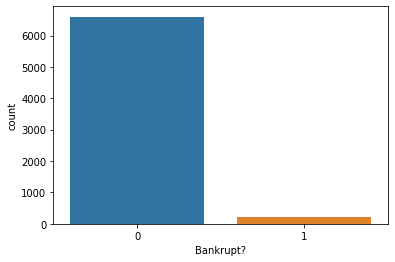

In [11]:
sns.countplot(x='Bankrupt?', data=df_bank)

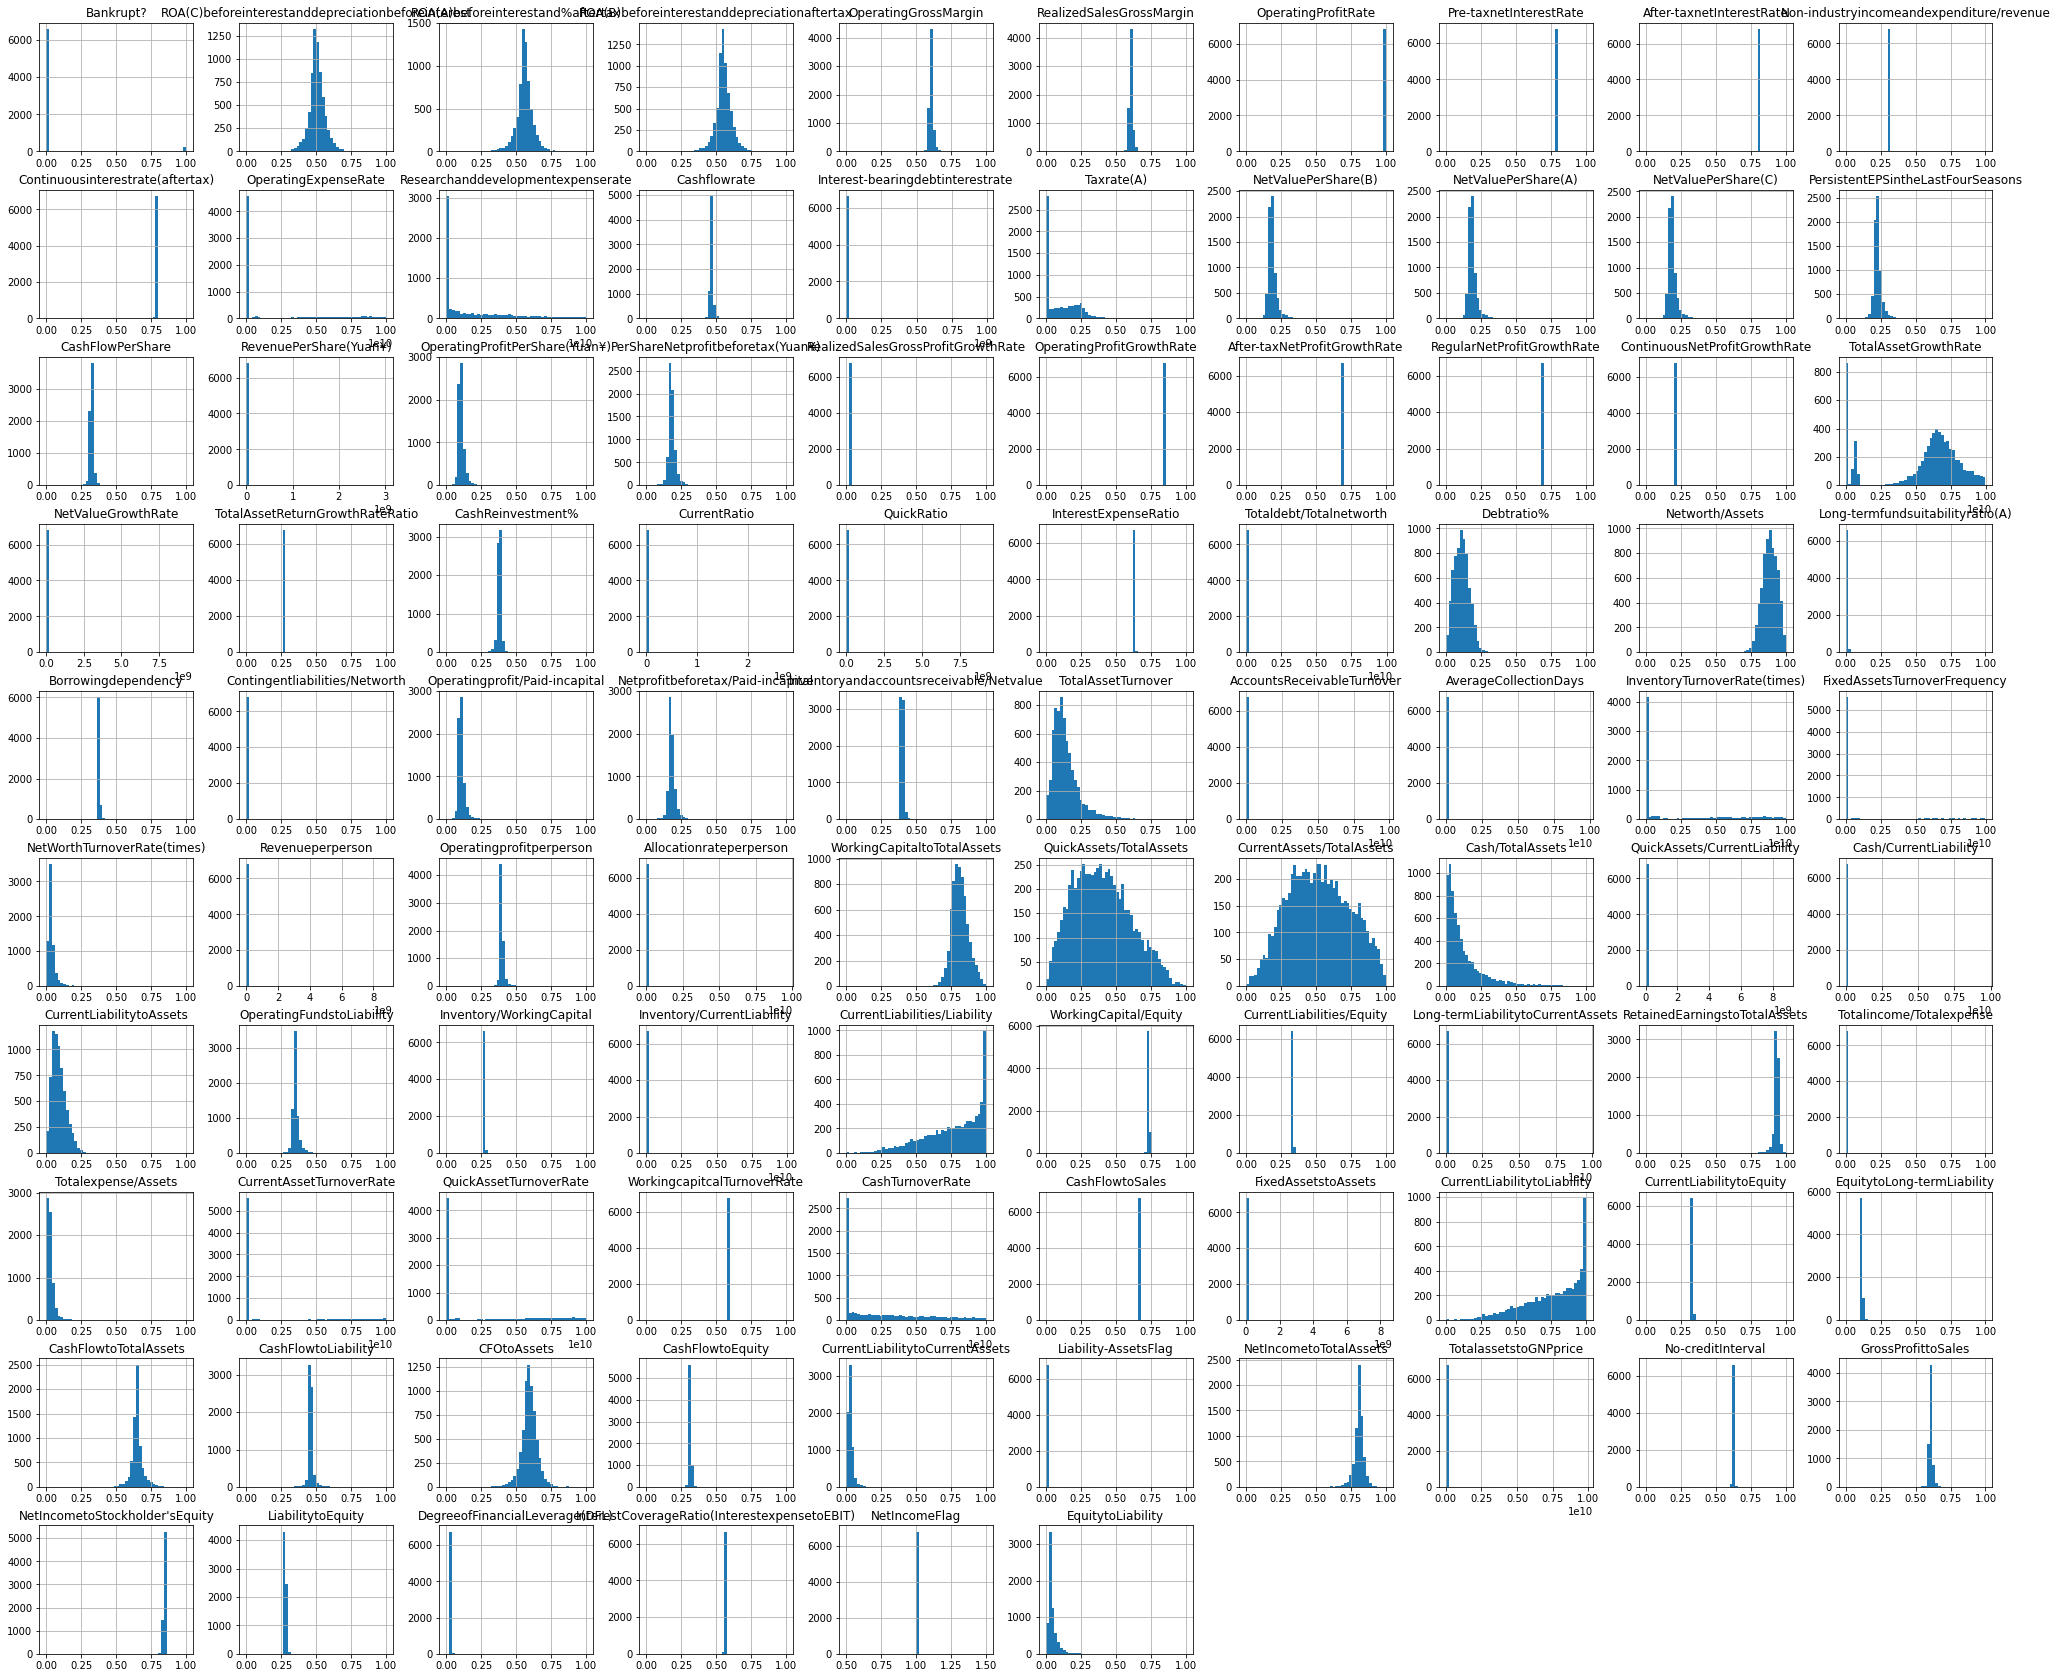

In [12]:
df_bank.hist(figsize = (35,30), bins = 50)
plt.show()

In [15]:
corr_matrix = df_bank.corr()

In [16]:
corr_matrix['Bankrupt?'][corr_matrix['Bankrupt?'] > 0]

Bankrupt?                                  1.000000
NetValueGrowthRate                         0.065329
QuickRatio                                 0.025058
Totaldebt/Totalnetworth                    0.012314
Debtratio%                                 0.250161
Long-termfundsuitabilityratio(A)           0.016920
Borrowingdependency                        0.176543
Contingentliabilities/Networth             0.070455
Inventoryandaccountsreceivable/Netvalue    0.075278
FixedAssetsTurnoverFrequency               0.072818
NetWorthTurnoverRate(times)                0.021089
Revenueperperson                           0.039718
Allocationrateperperson                    0.002829
Cash/CurrentLiability                      0.077921
CurrentLiabilitytoAssets                   0.194494
Inventory/CurrentLiability                 0.000822
CurrentLiabilities/Equity                  0.153828
Long-termLiabilitytoCurrentAssets          0.000778
Totalexpense/Assets                        0.139049
CurrentAsset

Text(0.5, 1.0, 'Correlation Housing Prices Features')

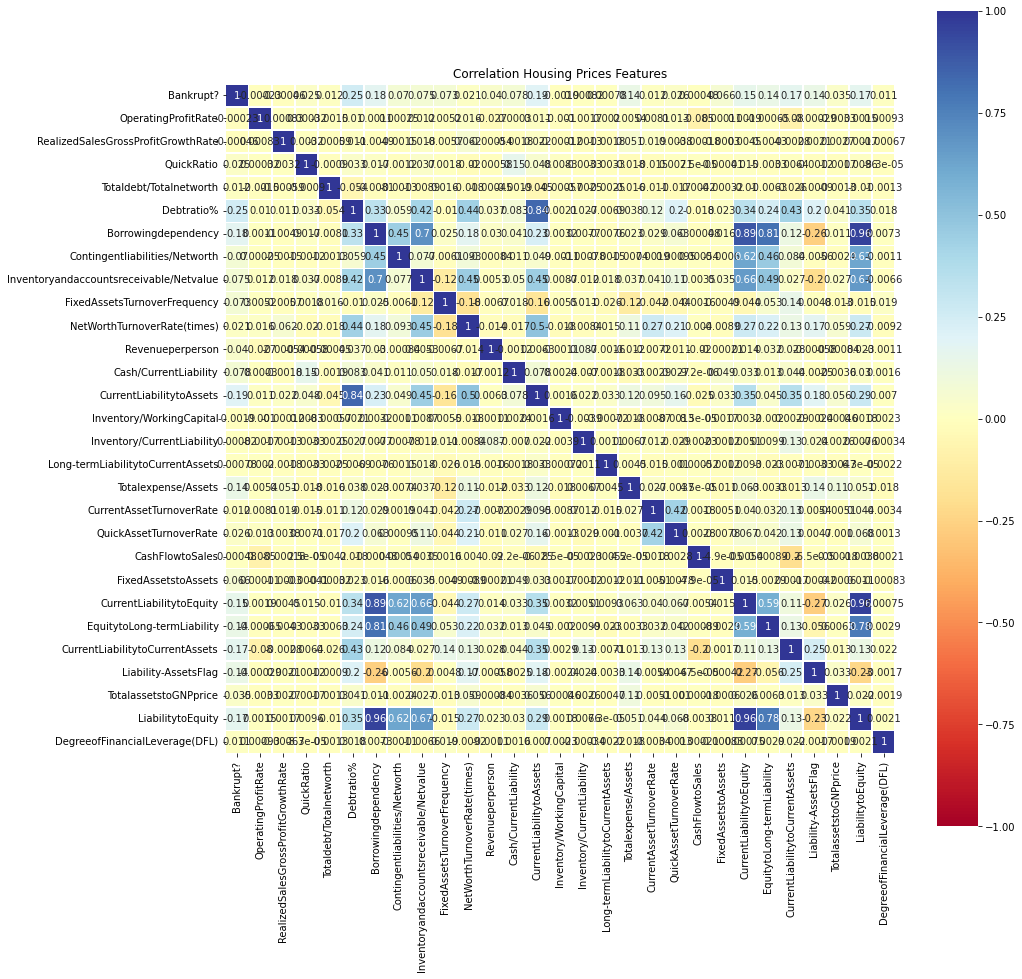

In [17]:
columns = ['Bankrupt?','OperatingProfitRate','RealizedSalesGrossProfitGrowthRate','QuickRatio','Totaldebt/Totalnetworth','Debtratio%','Borrowingdependency','Contingentliabilities/Networth',
           'Inventoryandaccountsreceivable/Netvalue','FixedAssetsTurnoverFrequency','NetWorthTurnoverRate(times)','Revenueperperson','Cash/CurrentLiability','CurrentLiabilitytoAssets',
           'Inventory/WorkingCapital','Inventory/CurrentLiability','Long-termLiabilitytoCurrentAssets','Totalexpense/Assets','CurrentAssetTurnoverRate',
           'QuickAssetTurnoverRate','CashFlowtoSales','FixedAssetstoAssets','CurrentLiabilitytoEquity','EquitytoLong-termLiability','CurrentLiabilitytoCurrentAssets','Liability-AssetsFlag',
           'TotalassetstoGNPprice','LiabilitytoEquity','DegreeofFinancialLeverage(DFL)']
df_bank_corr = df_bank[columns]
df_bank_corr.corr()

corrmat = df_bank_corr.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corrmat, vmin = -1, vmax = 1, square=True, annot = True, cmap = 'RdYlBu', linewidths =.5)
plt.title('Correlation Housing Prices Features')

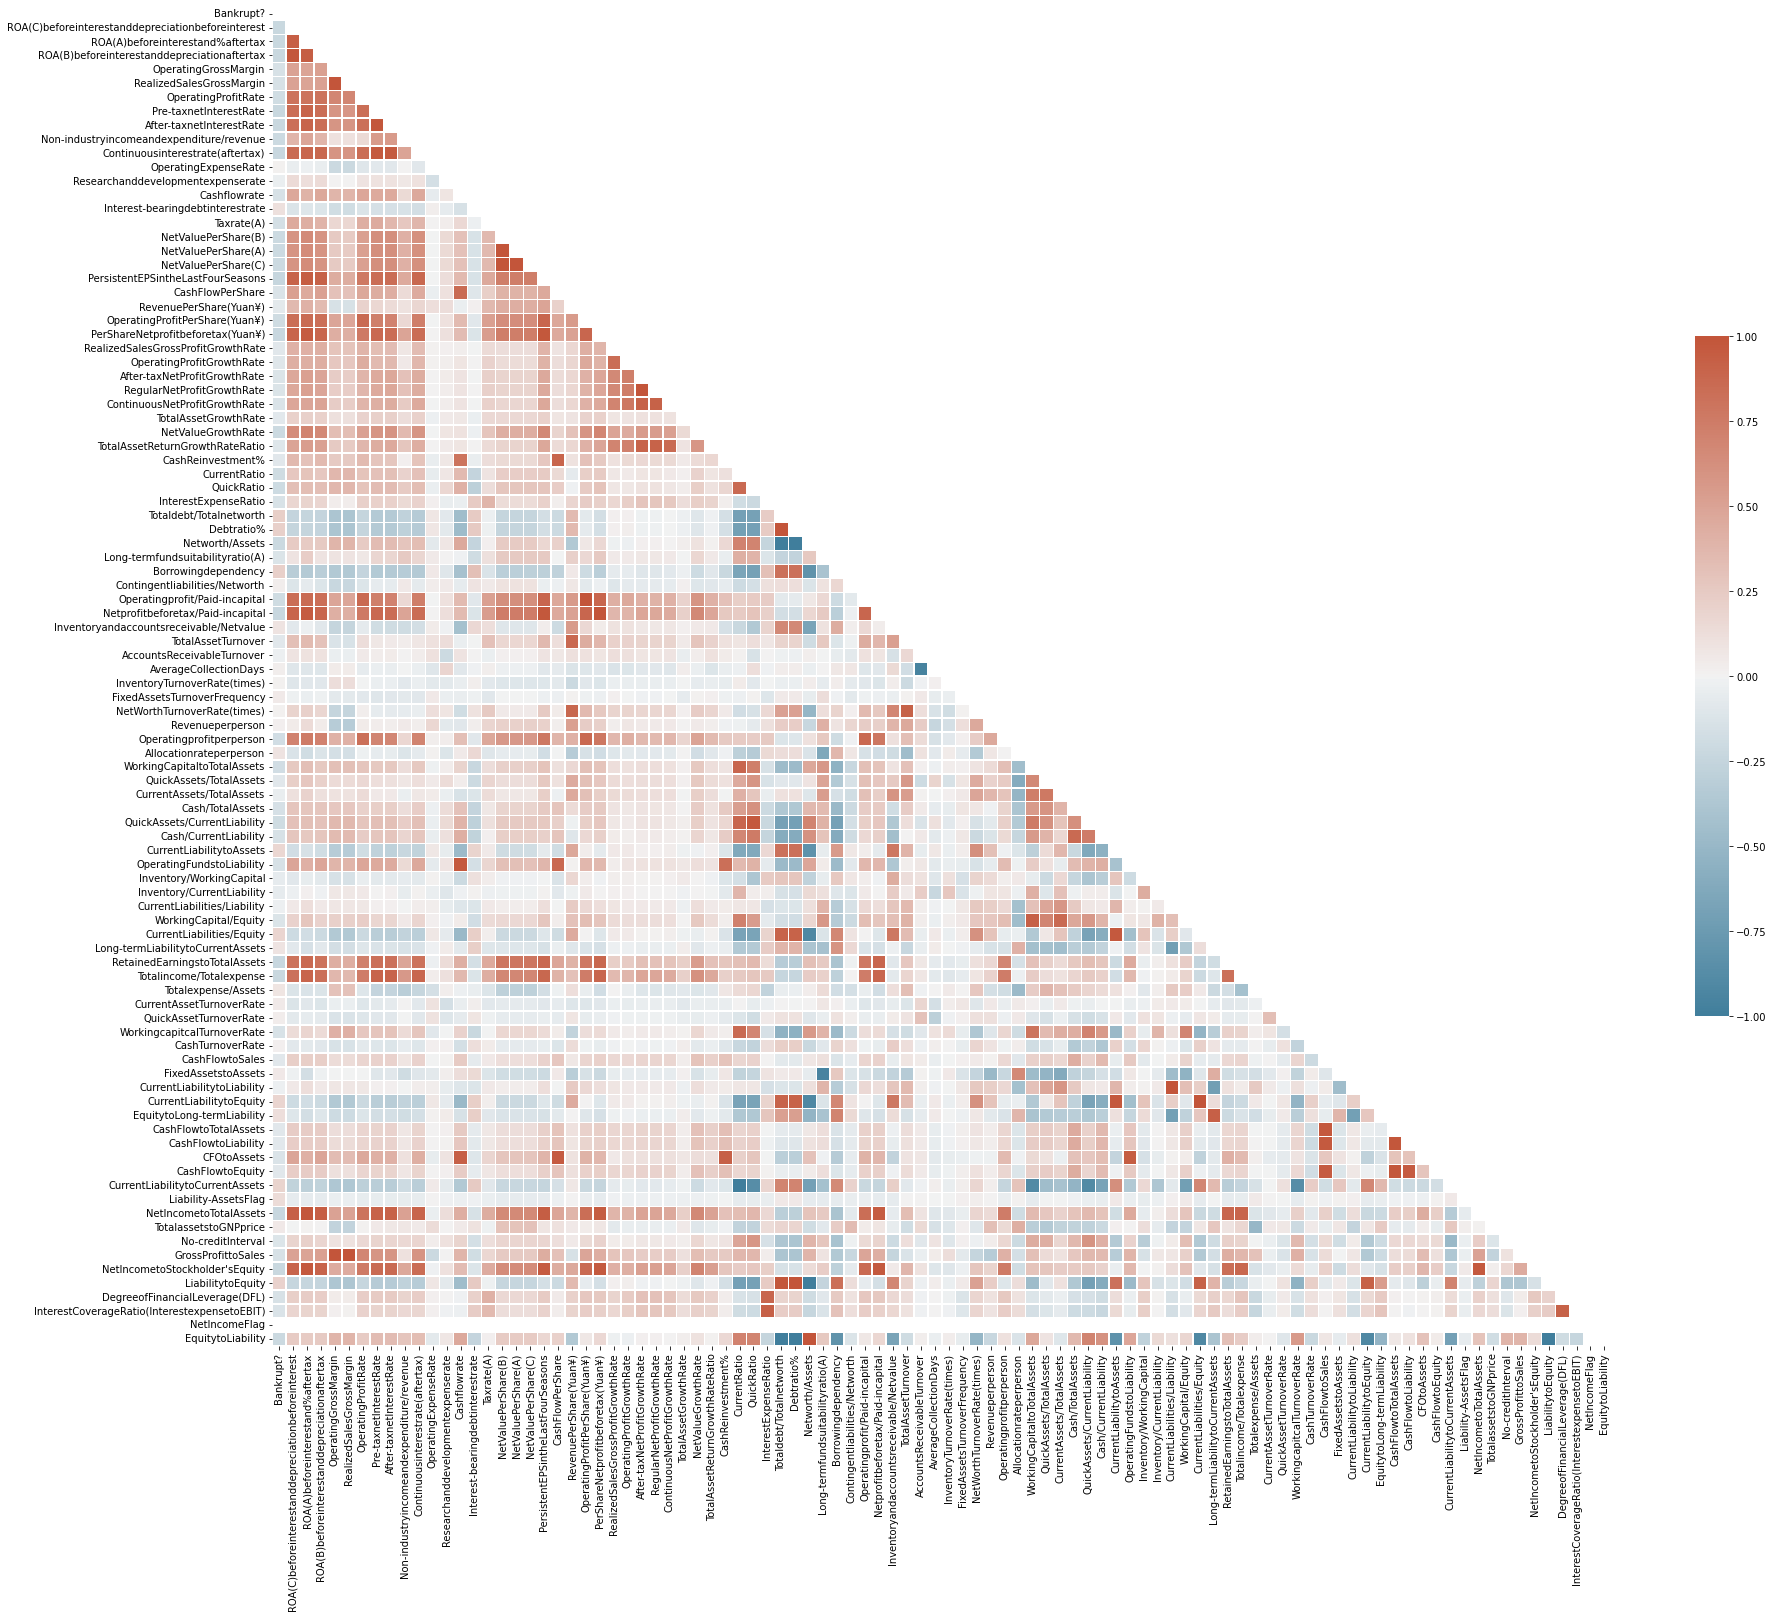

In [18]:
f, ax = plt.subplots(figsize=(30, 25))
mat = df_bank.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [20]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df_bank.values, i) for i in range(df_bank.shape[1])]
vif['variable'] = df_bank.columns
vif

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF,variable
0,1.255015e+00,Bankrupt?
1,6.930177e+01,ROA(C)beforeinterestanddepreciationbeforeinterest
2,4.425140e+01,ROA(A)beforeinterestand%aftertax
3,1.032851e+02,ROA(B)beforeinterestanddepreciationaftertax
4,6.557756e+07,OperatingGrossMargin
...,...,...
91,4.704476e+02,LiabilitytoEquity
92,1.004920e+00,DegreeofFinancialLeverage(DFL)
93,1.006994e+00,InterestCoverageRatio(InterestexpensetoEBIT)
94,0.000000e+00,NetIncomeFlag


In [21]:
# random_state = 42 allows code to always generate the same shuffled indices
train_set, test_set = train_test_split(df_bank, test_size=0.2, random_state=42)

In [22]:
df_train = train_set.copy()

### Model Selection

#### SGD Classifier

In [56]:
y_train = df_train['Bankrupt?']
x_train = df_train.drop('Bankrupt?', axis=1)

In [57]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train)


SGDClassifier(random_state=42)

In [58]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.9675646 , 0.96754675, 0.94939494])

Due to the nature of classification models, cross-validation accuracy is not a good measure of performance especially in skewed data sets like the one I am currently working with. There are significantly more companies that have not gone bankrupt than have gone bankrupt therefore it wouldn't be the hard to always "guess" that a company did not go bankrupt when that is most of the data. 

In [59]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=3)

In [68]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[5241,   45],
       [ 165,    4]])

A confusion matrix counts the number of instances that the model was able to classify bankcrupt (yes or no) properly. The first row is the negative class (not bankrupt) and the second row is the positive class (bankrupt). The first column represents the actual class and the second column represents the predicted class. The perfect classifier would produce non-zero values only in the top left and bottom right. This states that the model wrongly classified 45 companies as not bankcrupt (false positives) and wrongly classified 165 companies as bankcrupt (false negatives). 

In [69]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred)

0.08163265306122448

In [70]:
recall_score(y_train, y_train_pred)

0.023668639053254437

In [71]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.03669724770642201

In [72]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred)

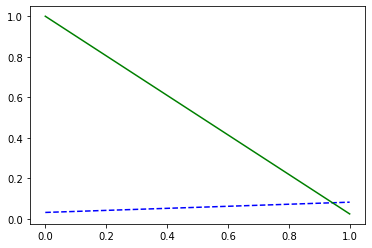

In [73]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Above we looked at precision, recall, and F score. Our current classifier has 2.4% precision, 3.7% recall, and an F score of 0.037. Depending on what the business question is, adjustments for precision and recall may need to be made. For this model, all of the numbers are too low therefore suggesting that this classifier is not a good fit for this data. 

In [74]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)

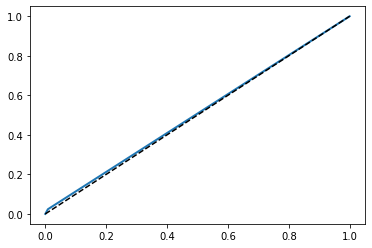

In [75]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 

plot_roc_curve(fpr, tpr)
plt.show()

In [76]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_train_pred)

0.5075777928523934

#### SVM Classifier

In [95]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(x_train, y_train) 

SVC()

In [82]:
some_scores = svm_clf.decision_function(df_bank.drop('Bankrupt?', axis=1))
some_scores

array([-1.0002069 , -1.00156601, -0.74544219, ..., -1.00027777,
       -1.02566315, -1.00078933])

In [84]:
np.argmax(some_scores)

5228

In [85]:
svm_clf.classes_

array([0, 1])

In [96]:
cross_val_score(svm_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.9686641 , 0.96919692, 0.96919692])

In [98]:
#what changed here compared to when using SGD??
y2_train_pred = cross_val_score(svm_clf, x_train, y_train, cv=3, scoring="accuracy")

In [99]:
# hmmmm not sure why this isn't working.....
confusion_matrix(y_train, y2_train_pred)

ValueError: ignored

In [100]:
precision_score(y_train, y2_train_pred)

ValueError: ignored

#### Logistic Rregression